In [131]:

import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib

### Cleaning Data

In [73]:

def data_combine(data_dir,v_object_path,marker):
    import pandas as pd
    import os
 

    df=pd.DataFrame(columns=['Video id'])

    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            file=os.path.join(data_dir,file)
            print(file)
            
            data=pd.read_csv(file)
            print(f'the file has shape {data.shape}')
            df=pd.merge(data,df,how='outer',on='Video id')
            print('It has shape {} after merging'.format(df.shape))
    df=df.drop(['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0_x','Unnamed: 0_y'],axis=1)
    df=df.drop_duplicates(subset=['Video id'])
    df=df.drop('Gender',axis=1)
    print(f'shape after dropping duplicates on all {df.shape}')


# #### merge with video objects on video title####
    df['video_title']=df['video_title'].fillna('Missing')

    df['video_title']=df['video_title'].str.replace("[#|.|,|\||/|:]","").str.replace('(\&#39;)|(\&quot);',"").str.replace("&amp;","_")

    df['video_title']=df['video_title'].str.replace('CCSS 7 SP 3 video 1 Mean Median Mode','CCSS 7 SP 3   video 1   Mean Median Mode')
    df['video_title']=df['video_title'].str.replace('CCSS 7 SP 5 video 1 Understanding Probability','CCSS 7 SP 5   video 1   Understanding Probability')
    df['video_title']=df['video_title'].str.replace('I don&39;t get Constant','I dont get Constant')
    L1=list(df['video_title'].unique())
    L1.sort()
    L1
    label_df_narrow=pd.read_csv(v_object_path)
    df_185_all=pd.merge(df,label_df_narrow,how='outer',on='video_title')
    print(f'shape after merging with video objects {df_185_all.shape}')

    ####### clean the duplicates##############

    data0=pd.get_dummies(df_185_all[['IsFace']],columns=['IsFace'])
    new_name=pd.Series(data0.columns.to_list()).str.replace('IsFace_','')
    df_185_all0=df_185_all.drop('IsFace',axis=1)
    data0.columns=new_name
    df_185_all=pd.concat([df_185_all0,data0],axis=1)
    df_185_all=df_185_all.drop_duplicates(subset='Video id')
    print(f"shape after extending the 'IsFace' feature as it's causing duplicates {df_185_all.shape}")
    
    ####clean the lables to be binary labels#####
    conditions=[df_185_all['Label']=='Yes',
                df_185_all['Label'].isin(['Not Relevant','Not Revelant']),
                (df_185_all['Label']=='Not Educational')]
    choice=['Yes','No','No']
    df_185_all['label']=np.select(conditions, choice)
    df_185_all.drop('Label',axis=1,inplace=True)
    df_185_all=df_185_all[df_185_all['label']!='0']
    print(f"shape after cleaning the labels {df_185_all.shape}")
    df_185_all.to_csv('all_features_{}.csv'.format(marker),index=False)
  

    return df_185_all




In [122]:
df_185_all1=data_combine('185_row/','video_objects.csv','06042020')

185_row/185_video_wLabels.csv
the file has shape (187, 9)
It has shape (187, 9) after merging
185_row/face_profile_dd.csv
the file has shape (250, 3)
It has shape (255, 11) after merging
185_row/final_face_features.csv
the file has shape (185, 34)
It has shape (259, 44) after merging
185_row/final_hair_features.csv
the file has shape (185, 7)
It has shape (267, 50) after merging
185_row/genders.csv
the file has shape (185, 2)
It has shape (285, 51) after merging
185_row/liwc_narrow1.csv
the file has shape (186, 73)
It has shape (322, 123) after merging
185_row/metafeatures_videos_final.csv
the file has shape (185, 6)
It has shape (386, 128) after merging
185_row/myprosody_features_gender_tone.csv
the file has shape (183, 3)
It has shape (388, 130) after merging
185_row/myprosody_features_pronunciation.csv
the file has shape (183, 2)
It has shape (388, 131) after merging
185_row/noise.csv
the file has shape (184, 4)
It has shape (390, 134) after merging
185_row/numOfFacesInVideo_max.csv

In [116]:
# data=pd.read_csv('all_features_with_185row.csv')

pd.DataFrame(df_185_all1.columns,columns=['feature_list']).to_csv('feature_lists.csv',index=False)
print(df_185_all1['label'].value_counts(dropna=False))
print(f'there are {df_185_all1.shape[1]} features after combining')
df_cat=df_185_all1.select_dtypes('object_')
print(f'there are {df_cat.shape[1]} non-numerical features')
df_cat.columns


Yes    153
No      30
Name: label, dtype: int64
there are 159 features after combining
there are 23 non-numerical features


Index(['Video id', 'transcript', 'audio_gender', 'audio_tone', 'gender_valid',
       'Glasses', 'Blur - Blurlevel', 'Exposure - Exposurelevel',
       'Occlusion - Foreheadoccluded', 'Occlusion - Eyeoccluded',
       'Occlusion - Mouthoccluded', 'Noise - Noiselevel', 'Makeup - Eyemakeup',
       'Makeup - Lipmakeup', 'Hair - Invisible', 'cc_skill_code', 'code_desc',
       'video_link', 'published_at', 'video_title', 'video_desc',
       'channel_title', 'label'],
      dtype='object')

In [117]:

cat_list=['audio_gender', 'audio_tone', 'gender_valid',
       'Glasses', 'Blur - Blurlevel', 'Exposure - Exposurelevel',
       'Occlusion - Foreheadoccluded', 'Occlusion - Eyeoccluded',
       'Occlusion - Mouthoccluded', 'Noise - Noiselevel', 'Makeup - Eyemakeup',
       'Makeup - Lipmakeup', 'Hair - Invisible']
def convert_oh(df,cat_list,marker):
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()
    df_cat=df.select_dtypes('object_')
    for cat in cat_list:
        df[cat+'_1']=le.fit_transform(df[cat].astype(str))
        df.drop(cat,axis=1,inplace=True)
    df_cat1=df.select_dtypes('object_')
    print(f'converted {df_cat.shape[1]-df_cat1.shape[1]} category features')
    df.to_csv('all_features_OH_{}.csv'.format(marker),index=False)
    return df

In [118]:
df_all=convert_oh(df_185_all1,cat_list,'06042020')
df_all.head()

converted 13 category features


,Video id,wpm,transcript,pitch_tuning,Number of speakers,Profile faces,Front faces,median_flatness,count of number of 1s/total windows,Pronunciation score,...,Glasses_1,Blur - Blurlevel_1,Exposure - Exposurelevel_1,Occlusion - Foreheadoccluded_1,Occlusion - Eyeoccluded_1,Occlusion - Mouthoccluded_1,Noise - Noiselevel_1,Makeup - Eyemakeup_1,Makeup - Lipmakeup_1,Hair - Invisible_1
0,4dvG5PXUGFk,86.500000,Exception,0.48,NaN,0.0,0.0,0.000013,0.000000,89.829,...,2,3,1,1,1,1,3,2,2,1
1,ev8g5jdDxEA,70.842105,'next lesson applying the properties of operat...,-0.34,NaN,1.0,1.0,0.000187,0.000398,69.798,...,2,3,1,1,1,1,3,2,2,1
2,3USkdBSwdKs,22.600000,'okay let us understand about the multiplicati...,0.39,1.0,0.0,0.0,0.000097,0.037108,6.897,...,2,3,1,1,1,1,3,2,2,1
3,c0roInrdEMQ,50.166667,'hi Sam for muddy math where we clear up the m...,-0.23,NaN,0.0,2.0,0.000050,0.014746,70.338,...,1,1,0,0,0,0,1,0,0,0
4,ku1rHYu6K9Q,117.777778,'hi boys and girls welcome back and today abou...,0.29,1.0,0.0,0.0,0.000011,0.018043,84.846,...,2,3,1,1,1,1,3,2,2,1


#### Feature Engineering


In [119]:
def text_feat(data,feature):
    data[feature]=data[feature].astype(str)
    data['word_count'+"_"+feature]=data[feature].apply(lambda x: len(x.split(" ")))
    data['char_count'+"_"+feature]=data[feature].str.len()
    def avg_word(word):
        words=word.split( )
        return sum(len(word) for word in words)/len(words)
    data['avg_word'+"_"+feature]=data[feature].apply(lambda x: avg_word(x))
    data['uppercase'+"_"+feature]=data[feature].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    data['lowercase'+"_"+feature]=data[feature].apply(lambda x: len([x for x in x.split() if x.islower()]))
    return data

def add_text_feat(data,marker):
    import pandas as pd
    data['codeVideoDesc_WC_dif'] =data['word_count_code_desc']- data['word_count_video_desc']

    data['codeVideoDesc_CC_dif']=data['char_count_code_desc']- data['char_count_video_desc']
    data['codeVideoDesc_AvgW_dif']=data['avg_word_code_desc']- data['avg_word_video_desc']
    data['codeVideoDesc_UC_dif']=data['uppercase_code_desc']- data['uppercase_video_desc']
    data['codeVideoDesc_LC_dif']=data['lowercase_code_desc']- data['lowercase_video_desc']

    data['uppercase_video_title']=data['video_title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

    data['lowercase_video_title']=data['video_title'].apply(lambda x: len([x for x in x.split() if x.islower()]))

    data['codeTitle_WC_dif'] =data['word_count_code_desc']- data['word_count_video_title']

    data['codeTitle_CC_dif']=data['char_count_code_desc']- data['char_count_video_title']
    data['codeTitle_AvgW_dif']=data['avg_word_code_desc']- data['avg_word_video_title']
    data['codeTitle_UC_dif']=data['uppercase_code_desc']- data['uppercase_video_title']
    data['codeTitle_LC_dif']=data['lowercase_code_desc']- data['lowercase_video_title']
    print(f'shape after feature engineering {data.shape}')
    data.to_csv('all_features_cleaned_OH_FE_{}feats_{}.csv'.format(len(data.columns)-1,marker),index=False)
    return data

In [120]:

text_feat(df_all,'code_desc')
text_feat(df_all,'video_desc')
data=text_feat(df_all,'video_title')

df_fe=add_text_feat(data,'06042020')
print(f'created {df_fe.shape[1]-df_185_all1.shape[1]} custom features')

shape after feature engineering (183, 184)
created 0 custom features


In [123]:
print(f'created {df_fe.shape[1]-df_185_all1.shape[1]} custom features')
# df_185_all1.shape[1]

created 25 custom features


#### Separate Feature sets
+ visual sets:44
+ audio sets:8
+ liwc sets:72
+ meta sets:14
+ object sets: 20
+ derived sets:25


In [140]:
meta=['Video id','cc_skill_code', 'code_desc', 'video_link', 'published_at', 'video_title',
 'video_desc','channel_title','transcript', 'Views', 'Likes', 'Dislikes', 'Favorites', 'Comments']
liwc=['WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','shehe',
       'they','ipron','article','prep','auxverb','adverb','conj','negate','verb','adj','compare','interrog','number','quant',
        'affect','posemo','negemo','social','male','cogproc','insight','cause','discrep','tentat','certain','differ','percept',
        'see','hear', 'feel','bio','health','drives','affiliation','achieve','power','reward','focuspast','focuspresent',
        'focusfuture', 'relativ','motion','space','time','work','leisure','money','informal','netspeak','assent','nonflu','AllPunc','Dash','Quote','Apostro','Parenth','OtherP']
audio=[ 'median_flatness','count of number of 1s/total windows', 'pitch_tuning','wpm','Number of speakers','audio_tone_1','audio_gender_1','Pronunciation score']
visual=['Profile faces','Front faces', 'blondVal','brownVal','redVal','blackVal','grayVal','otherVal','Smile','Headpose - Pitch',
        'Headpose - Roll','Headpose - Yaw','gender_valid_1','Age','Facialhair - Moustache','Facialhair - Beard','Facialhair - Sideburns','Glasses_1',
        'Emotion - Anger','Emotion - Contempt','Emotion - Disgust','Emotion - Fear','Emotion - Happiness','Emotion - Neutral','Emotion - Sadness',
        'Emotion - Surprise','Blur - Blurlevel_1','Blur - Value','Exposure - Exposurelevel_1','Exposure - Value','Occlusion - Foreheadoccluded_1',
        'Occlusion - Eyeoccluded_1', 'Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Noise - Value','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Accessories - Type',
        'Accessories - Confidence','Hair - Bald','Hair - Invisible_1','Front face','Side profile','Voice only']
objects=['Text','Plot','Number','Symbol','Page','Word','Person','Diagram','Human','White Board','Document','Paper',
 'Handwriting', 'Plan', 'Face','Driving License','Electronics','Flyer','Measurements','Alphabet']
derived=['word_count_code_desc','char_count_code_desc','avg_word_code_desc','uppercase_code_desc','lowercase_code_desc','word_count_video_desc',
 'char_count_video_desc','avg_word_video_desc','uppercase_video_desc','lowercase_video_desc','word_count_video_title','char_count_video_title',
 'avg_word_video_title', 'uppercase_video_title','lowercase_video_title','codeVideoDesc_WC_dif','codeVideoDesc_CC_dif','codeVideoDesc_AvgW_dif',
 'codeVideoDesc_UC_dif','codeVideoDesc_LC_dif','codeTitle_WC_dif', 'codeTitle_CC_dif','codeTitle_AvgW_dif','codeTitle_UC_dif','codeTitle_LC_dif']

print(f'We have total {df_fe.shape[1]-1} features \n'
      f'{len(meta)} meta features\n'
      f'{len(liwc)} liwc features\n'
      f'{len(audio)} audio features\n'
      f'{len(visual)} visual features\n'
      f'{len(objects)} objects features\n'
      f'{len(derived)} derived features')

We have total 183 features 
14 meta features
72 liwc features
8 audio features
44 visual features
20 objects features
25 derived features


#### Feature Selection
+ kept 156 features that don't have much sparsity(less than 100 nulls)
+ create another set of features after getting rid of the sparsity

In [166]:
def get_below100_feat(datapath,marker):
    import numpy as np
    
    data=pd.read_csv(datapath)
    print(f'{data.shape[1]} features in the original data')
    zeros=pd.DataFrame((data==0).astype(int).sum(axis=0),columns=['num_zeros']).reset_index()
#     zeros=zeros.sort_values('num_zeros',ascending=False)
    zeros.to_csv('num_zeros_{}.csv'.format(marker),index=False)
    below_100=zeros[zeros['num_zeros']<100]
    print('{} features that have less than 100 zeros'.format(len(below_100)))
    dense_feat_list=list(below_100['index'].unique())
    below_100.to_csv('below_100_features_uord.csv',index=False)
    return dense_feat_list,below_100
    # below_100['index'].unique()
    # ===below is another way of doing it
    # nonZero_df=pd.DataFrame(valid_data.apply(lambda x:np.count_nonzero(x,axis=0)),columns=['num_non_zero']).reset_index()
    # nonZero_df.sort_values('num_non_zero')

In [167]:
datapath='all_features_cleaned_OH_FE_183feats_06042020.csv'
dense_feature,dense_df=get_below100_feat(datapath,'06042020')

184 features in the original data
156 features that have less than 100 zeros


In [172]:
"','".join(dense_df['index'])

"Video id','wpm','transcript','pitch_tuning','Number of speakers','median_flatness','count of number of 1s/total windows','Pronunciation score','Views','Likes','WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','they','ipron','article','prep','auxverb','adverb','conj','negate','verb','adj','compare','interrog','number','quant','affect','posemo','negemo','social','cogproc','insight','cause','discrep','tentat','certain','differ','percept','see','hear','bio','drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion','space','time','work','leisure','informal','netspeak','assent','nonflu','AllPunc','Dash','Apostro','OtherP','blondVal','brownVal','redVal','blackVal','grayVal','otherVal','Smile','Headpose - Pitch','Headpose - Roll','Headpose - Yaw','Age','Facialhair - Moustache','Facialhair - Beard','Facialhair - Sideburns','Emotion - Anger','Emotion - Contempt','Emotion - Disgust','Emo

In [273]:
meta_v2=['Video id','cc_skill_code', 'code_desc', 'video_link', 'published_at', 'video_title',
 'video_desc','channel_title','transcript', 'Views', 'Likes']
liwc_v2=['WC','Analytic','Clout','Authentic','Tone','WPS','Sixltr','Dic','function','pronoun','ppron','i','we','you','they','ipron','article','prep','auxverb',
         'adverb','conj','negate','verb','adj','compare','interrog','number','quant','affect','posemo','negemo','social','cogproc','insight','cause','discrep','tentat',
         'certain','differ','percept','see','hear','bio','drives','affiliation','achieve','power','reward','focuspast','focuspresent','focusfuture','relativ','motion',
         'space','time','work','leisure','informal','netspeak','assent','nonflu','AllPunc','Dash','Apostro','OtherP']
audio_v2=[ 'median_flatness','count of number of 1s/total windows', 'pitch_tuning','wpm','Number of speakers','audio_tone_1','audio_gender_1','Pronunciation score']
audio_v3=[ 'median_flatness','count of number of 1s/total windows', 'pitch_tuning','wpm','Number of speakers']
visual_v2=['blondVal','brownVal','redVal','blackVal','grayVal','otherVal','Smile','Headpose - Pitch','Headpose - Roll','Headpose - Yaw','Age','Facialhair - Moustache',
           'Facialhair - Beard','Facialhair - Sideburns','Emotion - Anger','Emotion - Contempt','Emotion - Disgust','Emotion - Fear','Emotion - Happiness',
           'Emotion - Neutral','Emotion - Sadness','Emotion - Surprise','Blur - Value','Exposure - Value','Noise - Value','Accessories - Type','Accessories - Confidence','Hair - Bald',
           'Voice only','gender_valid_1','Glasses_1','Blur - Blurlevel_1','Exposure - Exposurelevel_1','Occlusion - Foreheadoccluded_1',
           'Occlusion - Eyeoccluded_1','Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Hair - Invisible_1']

visual_v3=['blondVal','brownVal','redVal','blackVal','grayVal','otherVal','Smile','Headpose - Pitch','Headpose - Roll','Headpose - Yaw','Age','Facialhair - Moustache',
           'Facialhair - Beard','Facialhair - Sideburns','Emotion - Anger','Emotion - Contempt','Emotion - Disgust','Emotion - Fear','Emotion - Happiness',
           'Emotion - Neutral','Emotion - Sadness','Emotion - Surprise','Blur - Value','Exposure - Value','Noise - Value','Accessories - Type','Accessories - Confidence','Hair - Bald',
           'Voice only','Glasses_1','Blur - Blurlevel_1','Exposure - Exposurelevel_1','Occlusion - Foreheadoccluded_1',
           'Occlusion - Eyeoccluded_1','Occlusion - Mouthoccluded_1','Noise - Noiselevel_1','Makeup - Eyemakeup_1','Makeup - Lipmakeup_1','Hair - Invisible_1']
objects_v2=['Text','Plot','Number','Symbol','Page','Word','Diagram','White Board','Paper']
derived_v2=['word_count_code_desc','char_count_code_desc','avg_word_code_desc','lowercase_code_desc',
            'word_count_video_desc','char_count_video_desc','avg_word_video_desc','lowercase_video_desc','word_count_video_title',
            'char_count_video_title','avg_word_video_title','uppercase_video_title','lowercase_video_title','codeVideoDesc_WC_dif',
            'codeVideoDesc_CC_dif','codeVideoDesc_AvgW_dif','codeVideoDesc_LC_dif','codeTitle_WC_dif','codeTitle_CC_dif','codeTitle_AvgW_dif','codeTitle_UC_dif','codeTitle_LC_dif']
all_feat_v2=meta_v2+audio_v2+liwc_v2+visual_v2+objects_v2+derived_v2
print(f'We have total {len(all_feat_v2)} features \n'
      f'{len(meta_v2)} meta features,{len(meta)-len(meta_v2)} less\n'
      f'{len(liwc_v2)} liwc features,{len(liwc)-len(liwc_v2)} less\n'
      f'{len(audio_v2)} audio features,{len(audio)-len(audio_v2)} less\n'
      f'{len(visual_v2)} visual features,{len(visual)-len(visual_v2)} less\n'
      f'{len(objects_v2)} objects features,{len(objects)-len(objects_v2)} less\n'
      f'{len(derived_v2)} derived features,{len(derived)-len(derived_v2)} less')

We have total 155 features 
11 meta features,3 less
65 liwc features,7 less
8 audio features,0 less
40 visual features,4 less
9 objects features,11 less
22 derived features,3 less


### Modeling

In [287]:
def evaluate(x_train,x_test,y_train,y_test,marker):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    %matplotlib inline
    import warnings
    import joblib
    warnings.filterwarnings('ignore')
# name of models
    model_name_list=['Random Forest','XGboost']

    #instantiate the models

    model3=RandomForestClassifier(min_samples_split=2,random_state=0)
    model4=XGBClassifier(
                 learning_rate =0.01,
                #  max_depth=4,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective='binary:logistic',
                 n_jobs=4,
                 scale_pos_weight=1,
                 reg_alpha=0,
                 reg_lambda=1,
                 seed=100)

  
    #train and predict with each model
    df=pd.DataFrame({'dataset':[marker]})
    for i, model in enumerate([model3,model4]):
        model.fit(x_train, y_train)
#         joblib.dump(model,'models/model-{}-{}.joblib'.format(marker,i))
        y_proba=model.predict_proba(x_test)
    
        y_pred=model.predict(x_test)
        #insert results into the dataframe
        model_name=model_name_list[i]
        ROC=roc_auc_score(y_test,y_proba[:,1])
#         print(ROC)
        col_name=model_name+' ROC'
        df0=pd.DataFrame([ROC], columns=[col_name])
#         df0.set_index(marker)
        df=pd.concat([df,df0],axis=1)

    return df

def evaluate_plot(x_train,x_test,y_train,y_test,marker):
    import pandas as pd
    import numpy as np
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    %matplotlib inline
    import warnings
    import joblib
    warnings.filterwarnings('ignore')
# name of models
    model_name_list=['Random Forest','XGboost']

    #instantiate the models

    model3=RandomForestClassifier(min_samples_split=2,random_state=0)
    model4=XGBClassifier(
                 learning_rate =0.01,
                #  max_depth=4,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective='binary:logistic',
                 n_jobs=4,
                 scale_pos_weight=1,
                 reg_alpha=0,
                 reg_lambda=1,
                 seed=100)

  
    #train and predict with each model
    df=pd.DataFrame({'dataset':[marker]})
    for i, model in enumerate([model3,model4]):
        model.fit(x_train, y_train)
        joblib.dump(model,'models/model-{}-{}.joblib'.format(marker,i))
        y_proba=model.predict_proba(x_test)
    
        y_pred=model.predict(x_test)
        #insert results into the dataframe
        model_name=model_name_list[i]
#         ROC=roc_auc_score(y_test,y_proba[:,1])
#         print(ROC)
#         col_name=model_name+' ROC'
#         df0=pd.DataFrame([ROC], columns=[col_name])
# #         df0.set_index(marker)
#         df=pd.concat([df0,df],axis=1)
#     print(df)

        print('----'+ model_name+'-----')
        import_feat=model.feature_importances_
        coefficients=pd.concat([pd.DataFrame(x_train.columns,columns=['predictors']),pd.DataFrame(np.transpose(import_feat),columns=['Feature_importance'])],axis=1)
        coefficients=coefficients.sort_values('Feature_importance',ascending=False).head(20)
        print(coefficients)
        cm=confusion_matrix(y_test,y_pred)
        cm=pd.DataFrame(cm,columns=['Predicted No','Predicted Yes'],index=['Actual No','Actual Yes'])
        print(cm)
#         results.ix[model_name,:]=[y_proba]
        skplt.metrics.plot_roc(y_test,y_proba,figsize=(8,6),title="{} ROC Curves for feature set '{}'".format(model_name,marker))
#         plt.show
        plt.savefig("plots/{} ROC Curves for feature set '{}'".format(model_name,marker))
        

#### Try a variety of feature sets
+ run random forest and xgboost model on meta, liwc,audio, visual, objects, derived (numerical featuers)

In [264]:
def feature_set_model(df,features,marker):
    df_X=df[features].select_dtypes(exclude=['object_']).fillna(0)
    df_y=df['label']
    x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
    df=evaluate(x_train, x_test,y_train,y_test,marker)
    return df
def feature_set_model_plots(df,features,marker):
    df_X=df[features].select_dtypes(exclude=['object_']).fillna(0)
    df_y=df['label']
    x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
    evaluate_plot(x_train, x_test,y_train,y_test,marker)
    

In [274]:
feat_dict={
    'meta':meta_v2,
    'liwc':liwc_v2,
    'audio':audio_v2,
    'visual':visual_v2,
    'objects':objects_v2,
    'derived':derived_v2,

    'liwc+audio':liwc_v2+audio_v2,
    'liwc+visual':liwc_v2+visual_v2,
    'liwc+objects':liwc_v2+objects_v2,
    'liwc+derived':liwc_v2+derived_v2,

    'visual+derived':visual_v2+derived_v2,
    'visual+meta+liwc':visual_v2+meta_v2+liwc_v2,
    'visual+liwc+objects':visual_v2+objects_v2+liwc_v2,
    'visual+derived+objects':visual_v2+objects_v2+derived_v2,
    'visual+liwc+derived':visual_v2+objects_v2+liwc_v2,
    'visual+liwc+derived+derived':visual_v2+objects_v2+liwc_v2+derived_v2,
    'visual+liwc+derived+derived+audio':visual_v2+objects_v2+liwc_v2+derived_v2+audio_v2,
    'visual_less+liwc+derived+derived+audio_less':visual_v3+objects_v2+liwc_v2+derived_v2+audio_v3,
}
df=pd.DataFrame(columns=['dataset','XGboost ROC',  'Random Forest ROC'])

for key, value in feat_dict.items():

    ddf=feature_set_model(df_fe,value,key)
    df=pd.concat([df,ddf],axis=0)


df.sort_values('Random Forest ROC',ascending=False)

,dataset,XGboost ROC,Random Forest ROC
0,visual+liwc+derived+derived,0.618280,0.715054
0,visual+meta+liwc,0.575269,0.690860
0,liwc,0.564516,0.666667
0,liwc+visual,0.586022,0.663978
0,visual+liwc+derived,0.596774,0.661290
0,visual+liwc+objects,0.596774,0.661290
0,visual,0.725806,0.661290
0,visual_less+liwc+derived+derived+audio_less,0.629032,0.653226
0,visual+derived+objects,0.682796,0.650538
0,visual+derived,0.626344,0.634409


#######Running models for feature set 'visual'#######
----Random Forest-----
                    predictors  Feature_importance
29              gender_valid_1            0.135546
7             Headpose - Pitch            0.071405
28                  Voice only            0.070168
24               Noise - Value            0.051908
9               Headpose - Yaw            0.050089
8              Headpose - Roll            0.048986
19           Emotion - Neutral            0.048782
23            Exposure - Value            0.048481
14             Emotion - Anger            0.044498
6                        Smile            0.039704
1                     brownVal            0.032934
3                     blackVal            0.031315
20           Emotion - Sadness            0.030642
27                 Hair - Bald            0.023844
0                     blondVal            0.023826
5                     otherVal            0.021464
22                Blur - Value            0.019893
32  E

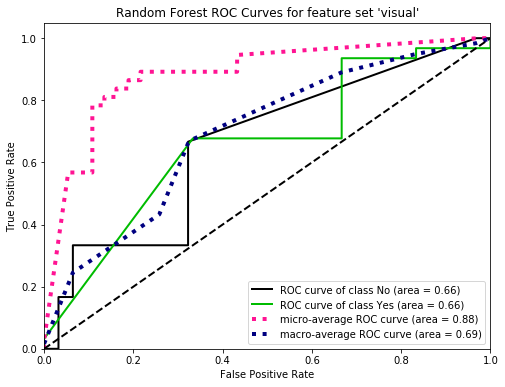

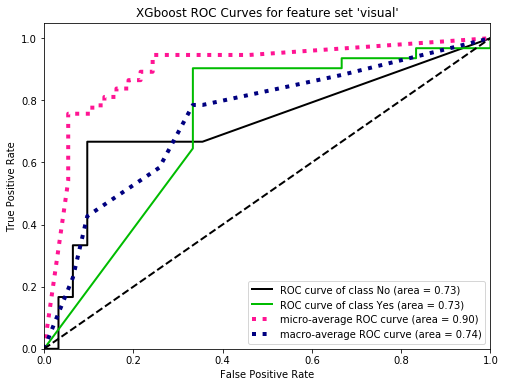

#######Running models for feature set 'visual+liwc+derived+derived'#######
----Random Forest-----
                 predictors  Feature_importance
123  char_count_video_title            0.029975
129  codeVideoDesc_AvgW_dif            0.028306
63                     they            0.028122
132        codeTitle_CC_dif            0.026795
135        codeTitle_LC_dif            0.025764
114    word_count_code_desc            0.024858
58                  pronoun            0.024409
50                 Analytic            0.023755
110                 AllPunc            0.022749
72                      adj            0.022342
104                    work            0.021168
117     lowercase_code_desc            0.019665
74                 interrog            0.018282
71                     verb            0.017851
128    codeVideoDesc_CC_dif            0.017560
130    codeVideoDesc_LC_dif            0.017315
57                 function            0.017158
116      avg_word_code_desc           

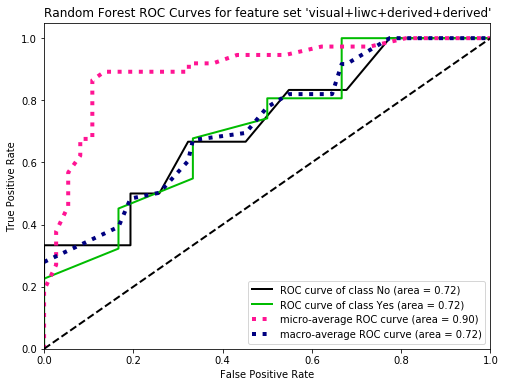

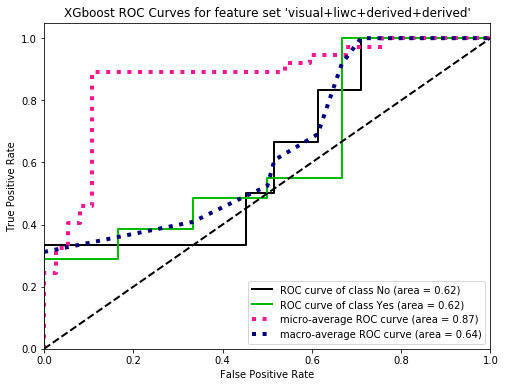

In [288]:
feat_dict={

    'visual':visual_v2,

    'visual+liwc+derived+derived':visual_v2+objects_v2+liwc_v2+derived_v2,
    
}

for key, value in feat_dict.items():
    print(f"#######Running models for feature set '{key}'#######")

    feature_set_model_plots(df_fe,value,key)

    plt.pause(0.0001)



In [279]:
df_v1=pd.read_csv('all_features_cleaned.csv')
print(df_v1.shape)

print(df_v1.columns.values)
df_v1.select_dtypes('object_').head()

(183, 156)
['Video id' 'Number of speakers' 'cc_skill_code' 'code_desc' 'video_link'
 'published_at' 'video_title' 'video_desc' 'channel_title' 'WC' 'Analytic'
 'Clout' 'Authentic' 'Tone' 'WPS' 'Sixltr' 'Dic' 'function' 'pronoun'
 'ppron' 'i' 'we' 'you' 'shehe' 'they' 'ipron' 'article' 'prep' 'auxverb'
 'adverb' 'conj' 'negate' 'verb' 'adj' 'compare' 'interrog' 'number'
 'quant' 'affect' 'posemo' 'negemo' 'social' 'male' 'cogproc' 'insight'
 'cause' 'discrep' 'tentat' 'certain' 'differ' 'percept' 'see' 'hear'
 'feel' 'bio' 'health' 'drives' 'affiliation' 'achieve' 'power' 'reward'
 'focuspast' 'focuspresent' 'focusfuture' 'relativ' 'motion' 'space'
 'time' 'work' 'leisure' 'money' 'informal' 'netspeak' 'assent' 'nonflu'
 'AllPunc' 'Dash' 'Quote' 'Apostro' 'Parenth' 'OtherP' 'Profile faces'
 'Front faces' 'median_flatness' 'count of number of 1s/total windows'
 'pitch_tuning' 'wpm' 'blondVal' 'brownVal' 'redVal' 'blackVal' 'grayVal'
 'otherVal' 'Smile' 'Headpose - Pitch' 'Headpose - Rol

,Video id,cc_skill_code,code_desc,video_link,published_at,video_title,video_desc,channel_title,Gender,Glasses,...,Exposure - Exposurelevel,Occlusion - Foreheadoccluded,Occlusion - Eyeoccluded,Occlusion - Mouthoccluded,Noise - Noiselevel,Makeup - Eyemakeup,Makeup - Lipmakeup,Hair - Invisible,transcript,label
0,7up731HX2uA,7.RP.A.2.D,"Explain what a point (x, y) on the graph of a ...",https://www.youtube.com/watch?v=7up731HX2uA,2015-01-26T19:24:25.000Z,[7RP2c-14] Graphing Proportional Relationships...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'Lydia is selling water bottles for two dollar...,Yes
1,7E64xzjsgpo,7.NS.A.2.C,Apply properties of operations as strategies t...,https://www.youtube.com/watch?v=7E64xzjsgpo,2015-10-12T21:06:40.000Z,Operation Properties Inverse Property 7 NS A 1...,video 5 of 5.,Math Man,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'welcome to our flipped classroom where knowle...,Yes
2,ibZmnFcLlaA,7.SP.C.7.A,Develop a uniform probability model by assigni...,https://www.youtube.com/watch?v=ibZmnFcLlaA,2015-01-26T19:25:53.000Z,[7SP7a-15] Uniform Probability Models - Common...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'a bag has 50 colored chips if 20 chips are re...,Yes
3,JmJAa90B_Qo,7.SP.C.7.B,Develop a probability model (which may not be ...,https://www.youtube.com/watch?v=JmJAa90B_Qo,2015-01-26T19:30:24.000Z,[7SP7b-11] Developing Probability Models - Com...,Discover more Common Core Math at https://www....,Freckle Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'before the experiment Lisbeth predicted that ...,Yes
4,hlD_j3AtxGs,7.G.A.3,Describe the two-dimensional figures that resu...,https://www.youtube.com/watch?v=hlD_j3AtxGs,2014-07-10T15:45:57.000Z,Math Shorts Episode 8 - Slicing Three Dimensio...,This Math Shorts episode helps students unders...,Planet Nutshell,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'math shirts slicing solid three-dimensional f...,Yes


In [282]:

df_v1=df_v1[~df_v1['label'].isnull()]
df_v1['label'].value_counts(dropna=False)

Yes    153
No      29
Name: label, dtype: int64

----Random Forest-----
         predictors  Feature_importance
16             they            0.027175
2          Analytic            0.026953
60             work            0.024542
39           tentat            0.023615
8               Dic            0.023392
42          percept            0.023002
27         interrog            0.022262
107           Views            0.019778
43              see            0.018091
35          cogproc            0.016556
88   Headpose - Yaw            0.016278
25              adj            0.015222
7            Sixltr            0.015055
26          compare            0.015031
52           reward            0.014749
40          certain            0.014574
33           social            0.014463
41           differ            0.014222
28           number            0.014091
17            ipron            0.013953
            Predicted No  Predicted Yes
Actual No              0              7
Actual Yes             0             30
----XGboost-----


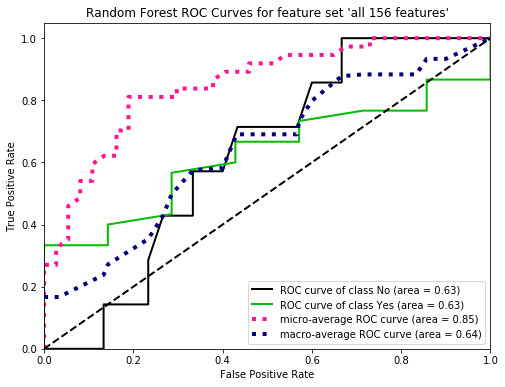

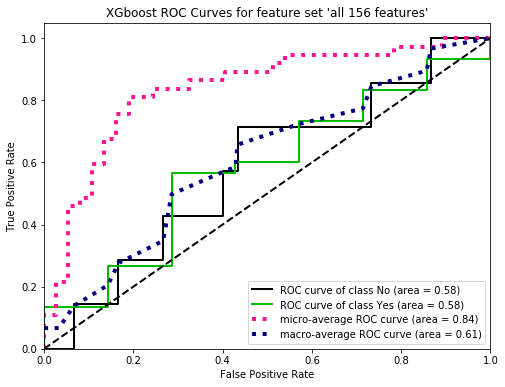

In [285]:
df_X=df_v1.select_dtypes(exclude=['object_']).fillna(0)
df_y=df_v1['label']
x_train, x_test,y_train,y_test=train_test_split(df_X,df_y,test_size=0.2,random_state=88)
evaluate_plot(x_train, x_test,y_train,y_test,'all 156 features')
# plt.pause(0.0001)